## Applying Tabular Methods

### Deterministic Q Learning

Import Statements

In [1]:
import gym as gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pickle

#### Frozen Lake Environment

Description: The agent is on a frozen lake and must navigate to the goal while avoiding holes and collecting Gems.

In [2]:
class FrozenLakeEnv(gym.Env):
    metadata = {'render.modes': []}
    def __init__(self, gamma=0.9, alpha=0.1, max_timestamp=10):
        self.gamma = gamma
        self.alpha = alpha

        self.obs_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timestamp = max_timestamp
        self.timestep = 0

        ## STATES SET #############
        self.state = np.zeros((4, 4))
        self.myskater = np.asarray([0, 0])
        self.goal_loc = np.asarray([3, 3])
        self.gem_loc = [np.asarray([0, 2]), np.asarray([3, 2])]
        self.hole_loc = [np.asarray([1, 3]), np.asarray([2, 0])]

        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4
        ##########################
        
        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.penalty_counter = 0  
        self.flag_out_grid = 0  


    def step(self, action):
        self.prev_state = np.copy(self.state)  
        self.prev_action = action  
        self.flag_out_grid = 0  

        ## ACTIONS SET #############
        if action == 0:    # moves right
            self.myskater[0] += 1
        elif action == 1:   # moves left
            self.myskater[0] -= 1
        elif action == 2:   # moves up
            self.myskater[1] += 1 
        elif action == 3:    # moves down
            self.myskater[1] -= 1
        ##########################
            
        self.myskater = np.clip(self.myskater, 0, 3)

        # If the agent is in the same position as the previous step, choose a different action
        prev_state_positions = np.argwhere(self.prev_state == 0.2)
        if len(prev_state_positions) > 0 and np.array_equal(self.myskater, prev_state_positions[0]):
            while action == self.prev_action:
                action = self.action_space.sample()
            self.flag_out_grid = 1

        self.state = np.zeros((4, 4))
        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        obs = self.state.flatten()
        reward = self.calculate_reward()
        penalty = any(np.array_equal(self.myskater, pos) for pos in self.hole_loc)
        if penalty:
            self.penalty_counter += 1 
        self.timestep += 1

        terminated = True if np.array_equal(self.myskater, self.goal_loc) else self.timestep >= self.max_timestamp
        truncated = True if np.any((self.myskater < 0) | (self.myskater > 3)) else False
        if truncated:
            self.flag_out_grid = 1  

        info = {}

        return self.state.flatten(), reward, terminated, truncated, info

    def reset(self, **kwargs):
        self.state = np.zeros((4, 4))
        self.myskater = np.asarray([0, 0])
        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8

        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.flag_out_grid = 0 
        
        obs = self.state.flatten()
        self.timestep = 0
        info = {}
        self.penalty_counter = 0
        return obs, info

    def calculate_reward(self):
        prev_myskateritions = np.argwhere(self.prev_state == 0.2)
        if prev_myskateritions.size == 0:
            prev_myskaterition = self.myskater
        else:
            prev_myskaterition = prev_myskateritions[0]

        # Calculating distance to goal before and after the step
        prev_distance_to_goal = np.linalg.norm(self.goal_loc - prev_myskaterition)
        current_distance_to_goal = np.linalg.norm(self.goal_loc - self.myskater)


        ## REWARDS SET #############
        if np.array_equal(self.myskater, self.goal_loc):
            reward = 10  # Positive reward for reaching goal
        elif np.array_equal(self.myskater, self.hole_loc[0]):
            reward = -5  # negative reward for reaching holes 1
        elif np.array_equal(self.myskater, self.hole_loc[1]):
            reward = -6   # negative reward for reaching holes 2
        elif np.array_equal(self.myskater, self.gem_loc[0]):
            reward = 5   # positive reward for reaching gems 1
        elif np.array_equal(self.myskater, self.gem_loc[1]):
            reward = 6  # positive reward for reaching gems 2
        elif current_distance_to_goal < prev_distance_to_goal:
            reward = 1  # Positive reward for moving closer to goal
        elif current_distance_to_goal > prev_distance_to_goal:
            reward = -1  # Negative reward for moving away to goal
        else:
            reward = -0.1  # Slight negative reward for no change
        ##########################
        
        return reward
    
    def get_penalty_count(self):
        return self.penalty_counter

    def render(self):
        fig, ax = plt.subplots()
        plt.title('Frozen Lake Environment')

        # Load and display the background image
        background_img = plt.imread('images/frozen_lake.jpg')
        ax.imshow(background_img, extent=(-0.5, 3.5, -0.5, 3.5), origin='upper')

       
        skater_img = plt.imread('images/icons8-skateboard-100.png')
        hole_img = plt.imread('images/icons8-hole-100.png')
        gem_img = plt.imread('images/icons8-gems-100.png')
        goal_img = plt.imread('images/icons8-flag-100.png')
        skater_hole_drown_img = plt.imread('images/agent_hole_drown.png')
        skater_gem_lottery_img = plt.imread('images/agent_gems_lottery.png')
        agent_flag_winner_img = plt.imread('images/agent_flag_winner.png')
        agent_grid_cross_img = plt.imread('images/agent_grid_cross.png')

        # Plot Skater
        myskater = self.myskater
        if self.flag_out_grid:
            skater_img = agent_grid_cross_img
        agent_box = AnnotationBbox(OffsetImage(skater_img, zoom=0.4), myskater, frameon=False)
        ax.add_artist(agent_box)

        # Plot Holes
        for hole_loc in self.hole_loc:
            hole_loc = hole_loc
            if np.array_equal(self.myskater, hole_loc):
                hole_img = skater_hole_drown_img
            else:
                hole_img = plt.imread('images/icons8-hole-100.png')
            rock_box = AnnotationBbox(OffsetImage(hole_img, zoom=0.4), hole_loc, frameon=False)
            ax.add_artist(rock_box)

        # Plot Gems
        for gem_loc in self.gem_loc:
            gem_loc = gem_loc
            if np.array_equal(self.myskater, gem_loc):
                gem_img = skater_gem_lottery_img
            else:
                gem_img = plt.imread('images/icons8-gems-100.png')
            battery_box = AnnotationBbox(OffsetImage(gem_img, zoom=0.4), gem_loc, frameon=False)
            ax.add_artist(battery_box)

        # Plot goal
        goal_loc = self.goal_loc
        goal_loc = self.goal_loc
        if np.array_equal(self.myskater, goal_loc):
            goal_img = agent_flag_winner_img
        else:
            goal_img = plt.imread('images/icons8-flag-100.png')
        goal_box = AnnotationBbox(OffsetImage(goal_img, zoom=0.4), goal_loc, frameon=False)
        ax.add_artist(goal_box)

        plt.xticks(np.arange(-0.5, 4.5, 1))
        plt.yticks(np.arange(-0.5, 4.5, 1))
        plt.gca().set_xticklabels(np.arange(-0.5, 4.5, 1))
        plt.gca().set_yticklabels(np.arange(-0.5, 4.5, 1))
        plt.show()

    def obs_space_to_index(self, obs):
        myskater = np.argwhere(obs.reshape(4, 4) == 0.2)
        if myskater.size == 0:
            return 0 
        return myskater[0, 0] * 4 + myskater[0, 1]



### 2.1 Q-learning

Apply Q-learning to solve both the deterministic and stochastic environments that were defined in
Part 1.

In [3]:
env_det = FrozenLakeEnv()

epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01  # Minimum exploration rate
gamma = 0.95  # Discount factor
alpha = 0.15  # Learning rate
decay_rate = 0.995  # Epsilon decay rate per episode
total_episodes = 1000 
max_timestamp = 10
qt = np.zeros((env_det.obs_space.n, env_det.action_space.n))

rewards_epi = []
epsilon_values = []
steps_per_episode = []
penalties_per_episode = []

final_state = None
for episode in range(total_episodes):
    state, _ = env_det.reset()
    state_index = env_det.obs_space_to_index(state)
    total_rewards = 0
    total_steps = 0  
    action = env_det.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[state_index])

    while True:
        next_state, reward, terminated, truncated, _ = env_det.step(action)
        total_steps += 1 
        next_strt_idx = env_det.obs_space_to_index(next_state)
        next_action = env_det.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[next_strt_idx])
        qt[state_index, action] = qt[state_index, action] + alpha * (reward + gamma * qt[next_strt_idx, next_action] - qt[state_index, action])
        state_index, action = next_strt_idx, next_action
        total_rewards += reward
        
        if terminated or truncated:
            break
    
    penalties_per_episode.append(env_det.get_penalty_count())  
    
    # Q-table for every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode: {episode + 1}")
        print("Q-table:")
        print(qt)
        avg_penalty = np.mean(penalties_per_episode[-100:])
        print(f"Average Penalties in Last 100 Episodes: {avg_penalty}")

    epsilon = max(epsilon_min, epsilon * decay_rate)
    epsilon_values.append(epsilon)
    rewards_epi.append(total_rewards)
    steps_per_episode.append(total_steps)

    if (episode + 1) % 100 == 0:
        average_steps = np.mean(steps_per_episode[-100:])
        print(f"Episode: {episode + 1}, Average Steps: {average_steps}")

    if episode == total_episodes - 1:
        final_state = env_det.state


Episode: 100
Q-table:
[[ 1.42723997  6.78999302  2.68193215  4.43591888]
 [ 2.16578485  3.54087052  8.75969117  0.87362594]
 [ 0.          0.          0.          0.        ]
 [-1.63683016  0.22204377  1.00913149  6.96256755]
 [-2.77629507  0.62622993  2.11969003 -0.7488315 ]
 [ 0.80695219  1.65217441  2.99716171 -0.93977439]
 [ 1.09276051  7.67247227 -2.60672768 -0.19942972]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.27226932 -0.5518115   1.29397071 -3.69723977]
 [ 1.99804948 -0.32304096  2.27838089 -0.48436502]
 [ 6.34819007 -1.11210861  1.39558805  0.02939428]
 [-0.2681253  -1.96242421  0.63446175  0.08252013]
 [-0.12551501 -0.06515363  0.         -0.81139608]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Average Penalties in Last 100 Episodes: 0.82
Episode: 100, Average Steps: 9.87
Episode: 200
Q-table:
[[ 7.76114247 14.75020672 10.29057532  9.41702406]
 [ 8.2520

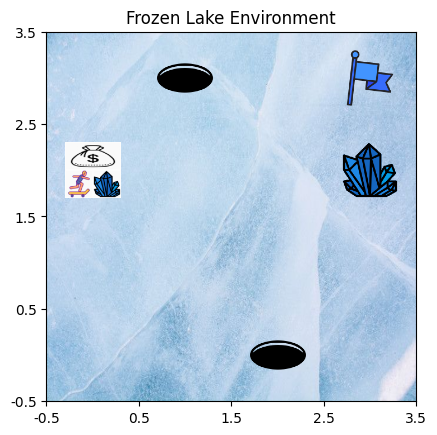

In [4]:
env_det.state = final_state
env_det.render()

Step 2:
Save the Q-table/Policy table as a pickle file or h5 of the trained model and attach it to your assignment submission.

In [5]:
import pickle
with open("models/charviku_assignment1_q_table_deterministic.pkl", 'wb') as file:
    pickle.dump(qt, file)

Step 3:

Provide the evaluation results:

(a) Print the initial Q-table and the trained Q-table

(b) Plot the total reward per episode graph (x-axis: episode, y-axis: total reward per episode).

(c) Plot the epsilon decay graph (x-axis: episode, y-axis: epsilon value)

(d) Run your environment for at least 10 episodes, where the agent chooses only greedy actions from the learned policy. Include a plot of the total reward per episode.

In [6]:
initial_qt = np.zeros((env_det.obs_space.n, env_det.action_space.n))
print("Initial Q-table:")
print(initial_qt)

Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [7]:
print("Trained Q-table:")
print(qt)

Trained Q-table:
[[29.16626439 40.67390223 49.11854347 41.48576772]
 [19.84489019 30.49336587 51.66496546 24.45948712]
 [ 0.          0.          0.          0.        ]
 [33.25051423 42.31258557 41.01500447 51.67166517]
 [ 2.01645929  9.46511197 27.14217769  5.85208184]
 [ 1.35803848 39.01322785  8.23219173  4.63761884]
 [ 3.91711126 42.21281234  5.50661414  2.72217745]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.27226932 -0.5518115   3.93319997 -2.21027338]
 [ 1.99804948  3.11979613 10.03760369 -0.31770528]
 [21.86636748 -1.00222599  1.39558805  1.45297177]
 [-0.15249571 -1.96242421  0.68929249  0.08252013]
 [-0.12551501 -0.06515363  2.01870384 -0.81139608]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


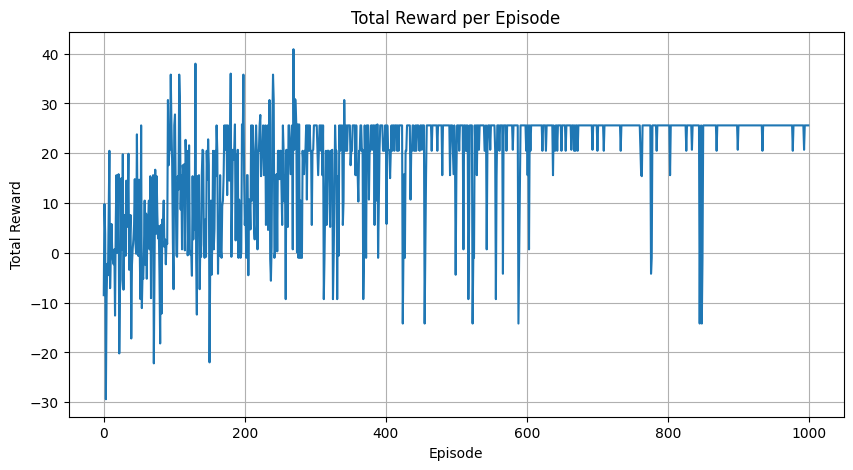

In [8]:
# total reward per episode graph
plt.figure(figsize=(10, 5))
plt.plot(rewards_epi)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()


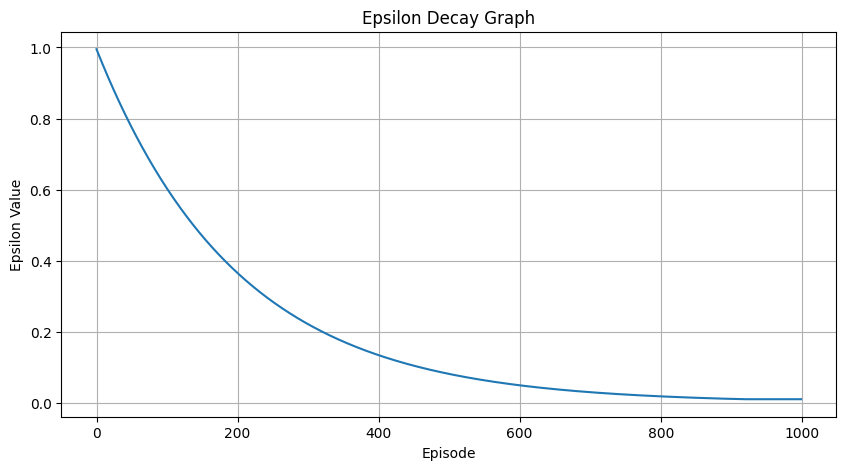

In [9]:
# epsilon decay graph
plt.figure(figsize=(10, 5))
plt.plot(epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay Graph')
plt.grid(True)
plt.show()

Episode 1000 Reward: 25.6
Episode 1000 Reward: 25.6
Episode 1000 Reward: 25.6
Episode 1000 Reward: 25.6
Episode 1000 Reward: 25.6
Episode 1000 Reward: 25.6
Episode 1000 Reward: 25.6
Episode 1000 Reward: 25.6
Episode 1000 Reward: 25.6
Episode 1000 Reward: 25.6


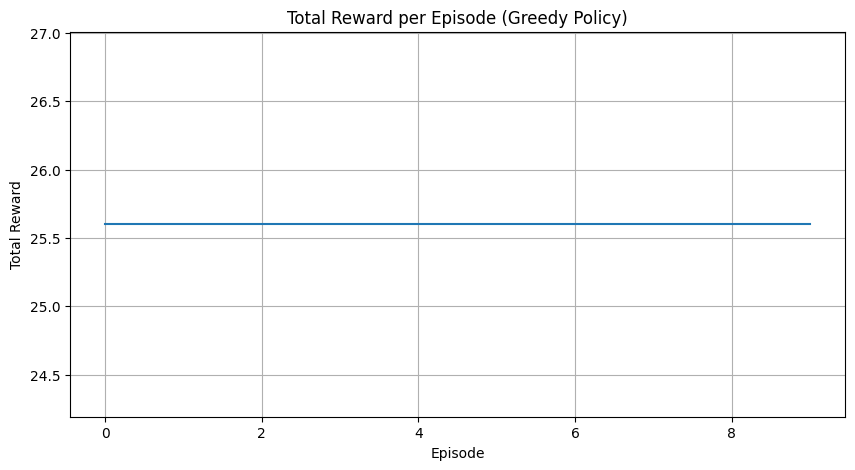

In [10]:
greedy_rewards = []
for _ in range(10):
    total_reward = 0
    state, _ = env_det.reset()
    state_index = env_det.obs_space_to_index(state)

    while True:
        action = np.argmax(qt[state_index])
        next_state, reward, terminated, truncated, _ = env_det.step(action)
        next_strt_idx = env_det.obs_space_to_index(next_state)
        total_reward += reward
        state_index = next_strt_idx
        if terminated or truncated:
            print(f"Episode {episode + 1} Reward: {round(total_reward, 4)}")
            break

    greedy_rewards.append(total_reward)

# total rewards for 10 episodes
plt.figure(figsize=(10, 5))
plt.plot(greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Greedy Policy)')
plt.grid(True)
plt.show()

Step 4. Hyperparameter Tuning: Select at least two hyperparameters to tune to get better results for Q-learning.
You can explore hyperparameter tuning libraries, e.g. Optuna or make it manually. Parameters to
tune (select 2):

• Discount factor (γ)

• Epsilon decay rate

• Epsilon min/max values

• Number of episodes

• Max timesteps

Try at least 3 different values for each of the parameters that you choose

In [11]:
performance_dict = {}

def training_loop(env, g , max_timestamp):
    alpha = 0.15  # Learning rate
    gamma = g  # Discount factor
    epsilon = 1.0  # Initial exploration rate
    epsilon_min = 0.01  # Minimum exploration rate
    decay_rate = 0.995  # Epsilon decay rate per episode
    total_episodes = 1000
    max_timestamp = max_timestamp

    qt = np.zeros((env.obs_space.n, env.action_space.n))

    rewards_epi = []
    epsilon_values = []
    steps_per_episode = []
    penalties_per_episode = []

    final_state = None
    for episode in range(total_episodes):
        state, _ = env.reset()
        state_index = env.obs_space_to_index(state)
        total_rewards = 0
        total_steps = 0 
        action = env.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[state_index])

        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_steps += 1 
            next_strt_idx = env.obs_space_to_index(next_state)
            next_action = env.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[next_strt_idx])
            qt[state_index, action] = qt[state_index, action] + alpha * (reward + gamma * qt[next_strt_idx, next_action] - qt[state_index, action])
            state_index, action = next_strt_idx, next_action
            total_rewards += reward
            
            if terminated or truncated:
                break
        
        penalties_per_episode.append(env.get_penalty_count())              
        epsilon = max(epsilon_min, epsilon * decay_rate)
        epsilon_values.append(epsilon)
        rewards_epi.append(total_rewards)
        steps_per_episode.append(total_steps)

        if episode == total_episodes - 1:
            final_state = env.state
        
    final_reward = np.mean(rewards_epi[-100:]) 
    performance_dict[(alpha, gamma, max_timestamp)] = final_reward
    return qt, rewards_epi, epsilon_values, final_state
        


In [12]:
def evaluate_loop(env, max_timestamp, gamma, qt, rewards_epi, epsilon_values, final_state):
    print(f"Max Timestamp, Gamma:  {max_timestamp}, {gamma}")

    initial_qt = np.zeros((env.obs_space.n, env.action_space.n))
    print("Initial Q-table:")
    print(initial_qt)
    print("\nTrained Q-table:")
    print(qt)


    plt.figure(figsize=(10, 5))
    plt.plot(rewards_epi)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epsilon_values)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay Graph')
    plt.grid(True)
    plt.show()

    greedy_rewards = []
    for _ in range(10):
        total_reward = 0
        state, _ = env.reset()
        state_index = env.obs_space_to_index(state)

        while True:
            action = np.argmax(qt[state_index])
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_strt_idx = env.obs_space_to_index(next_state)
            total_reward += reward
            state_index = next_strt_idx

            if terminated or truncated:
                print(f"Episode {episode + 1} Reward: {round(total_reward, 4)}")
                break

        greedy_rewards.append(total_reward)

    plt.figure(figsize=(10, 5))
    plt.plot(greedy_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode (Greedy Policy)')
    plt.grid(True)
    plt.show()

    env.state = final_state
    env.render()   

Step 5.

Provide the evaluation results (refer to Step 3) and your explanation for each result for each hyperparameter.
In total, you should complete Step 3 seven times [Base model (step 1) + Hyperparameter #1
x 3 difference values & Hyperparameter #2 x 3 difference values]. Make your suggestion on the most
efficient hyperparameters values for your problem setup.

Max Timestamp, Gamma:  12, 0.1
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 0.70128891  0.48955963  0.23607475  0.33266509]
 [ 1.08702797  0.36307403  5.08780197 -0.90639958]
 [ 0.          0.          0.          0.        ]
 [-4.79747763  0.34556696  0.38413268  5.05522136]
 [-5.90259159 -0.92250973  1.15055671 -0.07063261]
 [ 1.00410768 -0.55147075  1.50737822 -0.99751873]
 [ 1.59531993  5.09771241 -4.94122481 -0.85237755]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 1.05468693 -0.90113998  1.54831217 -5.51189648]
 [ 6.05241636 -0.69706466  1.4869541  -0.92045778]
 [10.05055691 -3.07226193  0.2371077  -0.35217874]
 [-0.01111405 -3.72857365  1.52383249 -0.04782001]
 [ 0.10655676 -0.61520817  6.0

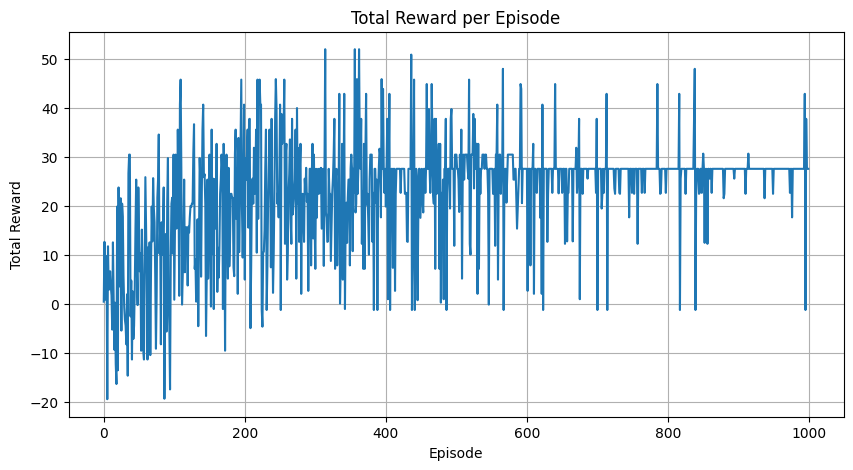

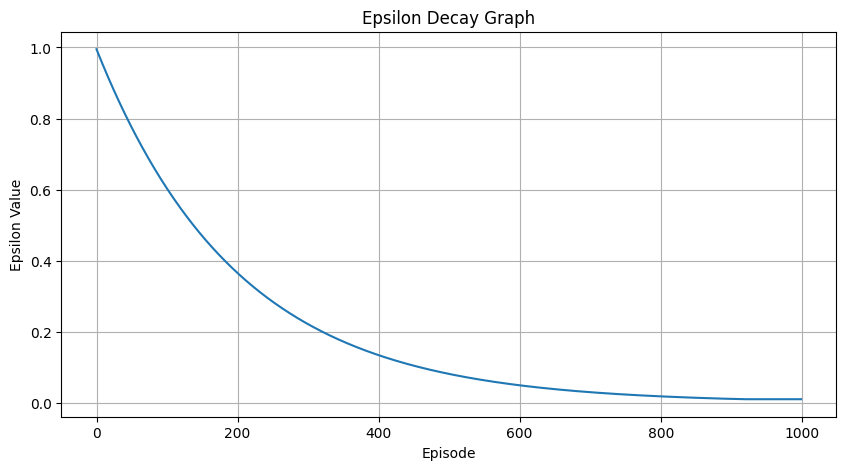

Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6


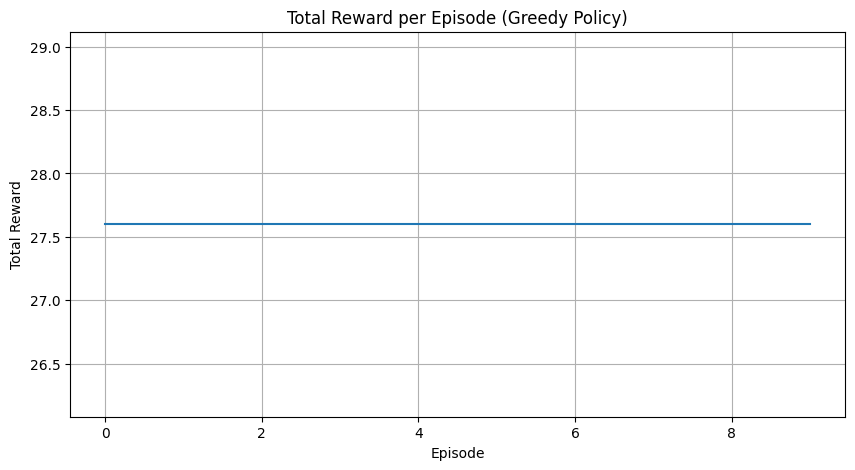

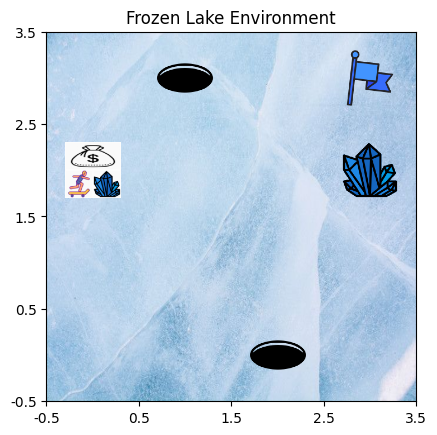

Max Timestamp, Gamma:  12, 0.5
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 3.12662213  1.94302733  2.64006334  2.16075216]
 [ 2.8492983   2.72426569  6.70209254  0.40893468]
 [ 0.          0.          0.          0.        ]
 [-3.64805603  3.16544888  3.23090774  6.69616825]
 [-4.87645958  0.48033229  3.12848353  0.70283773]
 [ 2.10644577  1.63795202  4.29348875  0.07703423]
 [ 4.70437984  6.57464182 -3.76428437  0.96624764]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.67149376 -0.18564628  2.44704661 -4.48170537]
 [ 7.51012822  1.30465036  2.92269992 -0.42061654]
 [11.09737385 -0.64794428 -0.01920875  1.0882105 ]
 [-0.04398611 -3.32594285  3.00175087  0.02229134]
 [ 1.09286629 -1.24377161  7.2

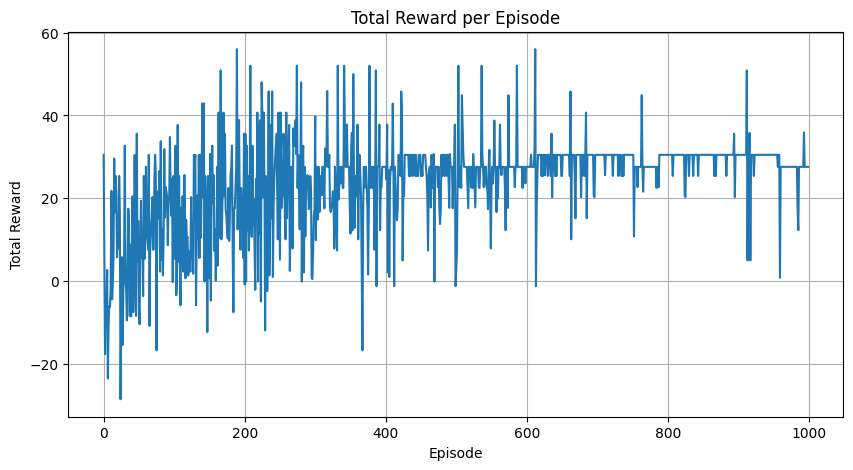

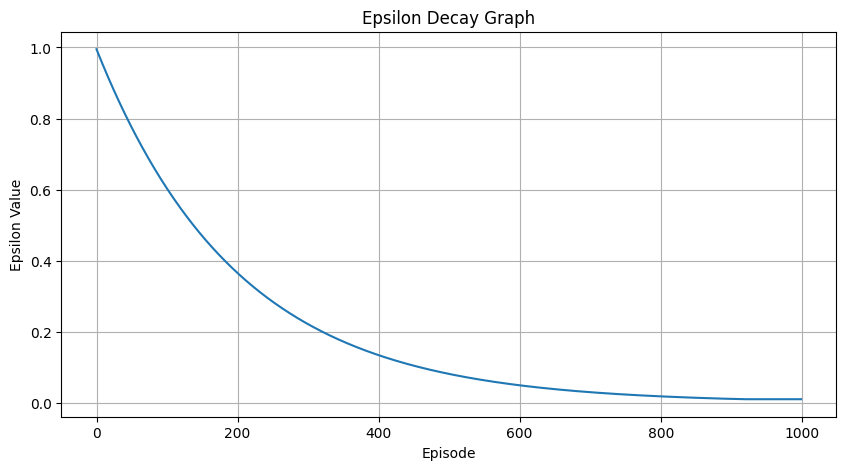

Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6
Episode 1000 Reward: 27.6


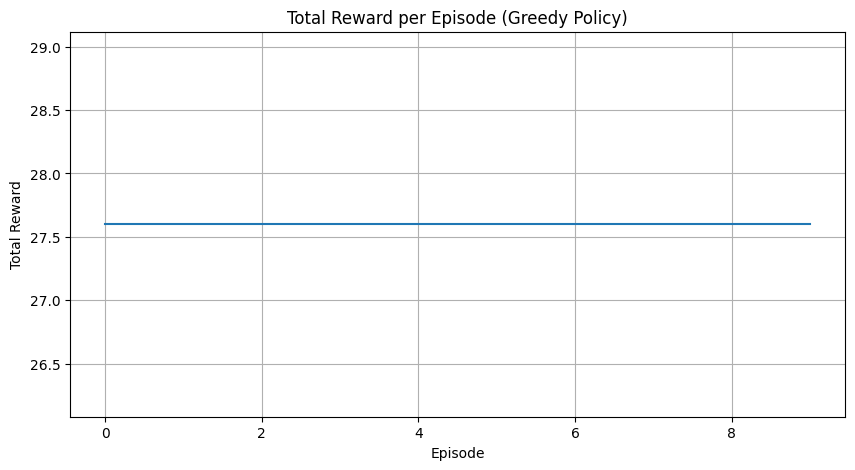

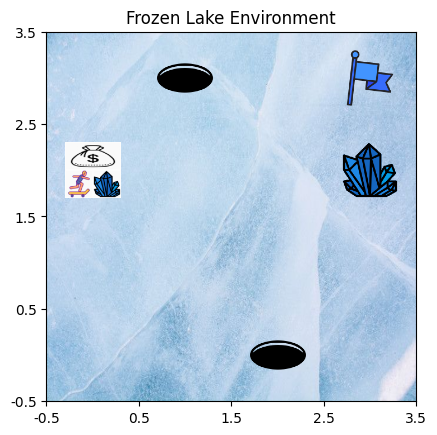

Max Timestamp, Gamma:  12, 0.9
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[19.83010504 22.83515236 23.75695764 21.89441601]
 [16.02037777 20.81787055 26.44943996 16.08727701]
 [ 0.          0.          0.          0.        ]
 [13.6704087  22.68434933 22.83721904 26.39307763]
 [ 4.52712471  9.78119451 17.734098    6.71689508]
 [ 4.6560336   9.59829887 21.18766251  3.16233283]
 [10.9218138  25.46001904  7.34764621 11.01129536]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.73828176  0.46037382  9.05304206 -1.03504591]
 [18.24686906  7.43856995  3.52375454  0.6455719 ]
 [18.42431836 -1.4009466   0.45395413  2.68521378]
 [ 0.03220696  0.          2.44689743  0.10999514]
 [ 0.32868316 -1.34936326  9.8

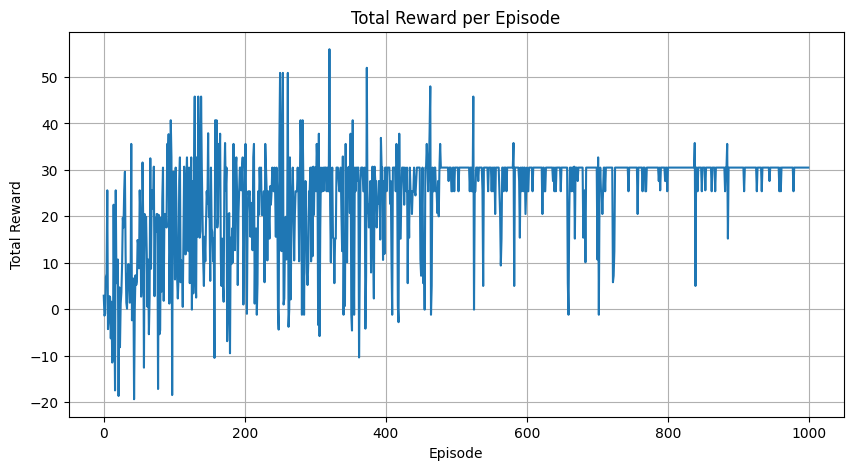

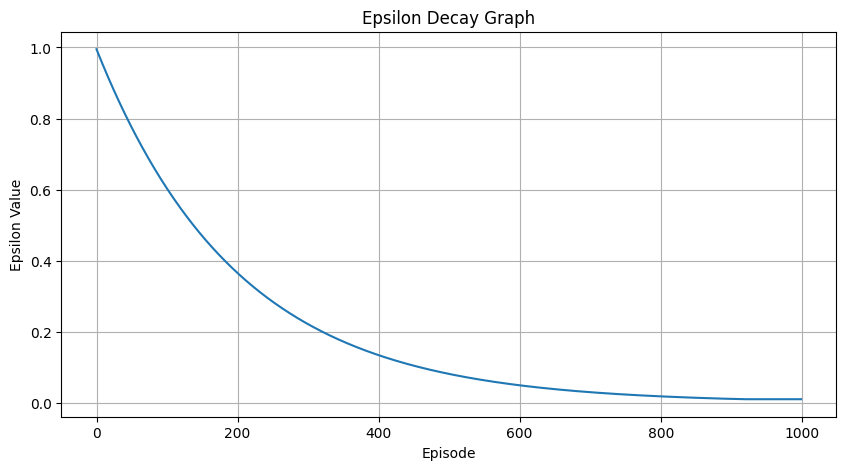

Episode 1000 Reward: 30.5
Episode 1000 Reward: 30.5
Episode 1000 Reward: 30.5
Episode 1000 Reward: 30.5
Episode 1000 Reward: 30.5
Episode 1000 Reward: 30.5
Episode 1000 Reward: 30.5
Episode 1000 Reward: 30.5
Episode 1000 Reward: 30.5
Episode 1000 Reward: 30.5


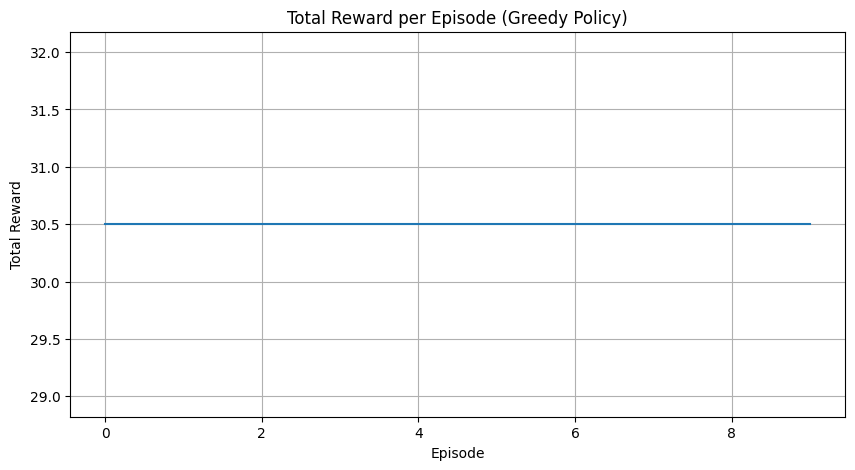

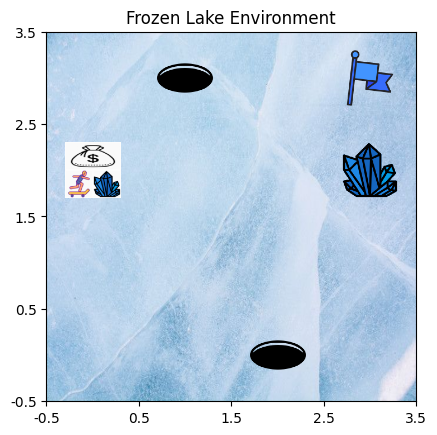

Max Timestamp, Gamma:  15, 0.1
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 0.38598867  0.37505831  0.47814323  0.37798414]
 [ 1.12105258  0.29147459  5.0635568  -0.87008789]
 [ 0.          0.          0.          0.        ]
 [-4.93083753  0.32707596  0.29648978  5.05290918]
 [-5.92285113 -0.89230086  1.15050703 -0.09782819]
 [ 1.08491793 -0.5496037   1.5050686  -0.90639325]
 [ 1.60585165  5.05110866 -4.94084738 -0.85997382]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 1.56436209 -0.8946854   1.22374594 -5.63628694]
 [ 6.06992633 -0.64598325  1.27094172 -0.91966896]
 [10.05712718 -3.08735902 -0.02947798 -0.18586529]
 [-0.08897669 -4.32524203  1.41613626 -0.06333291]
 [ 0.13022998 -0.96389529  6.1

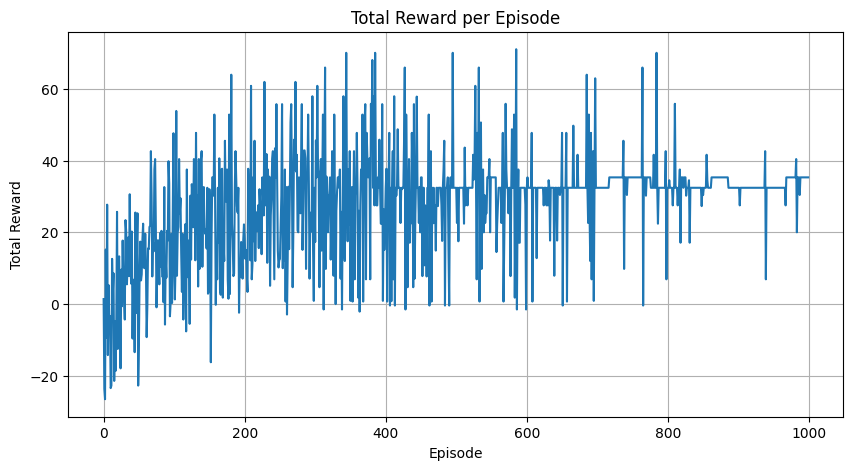

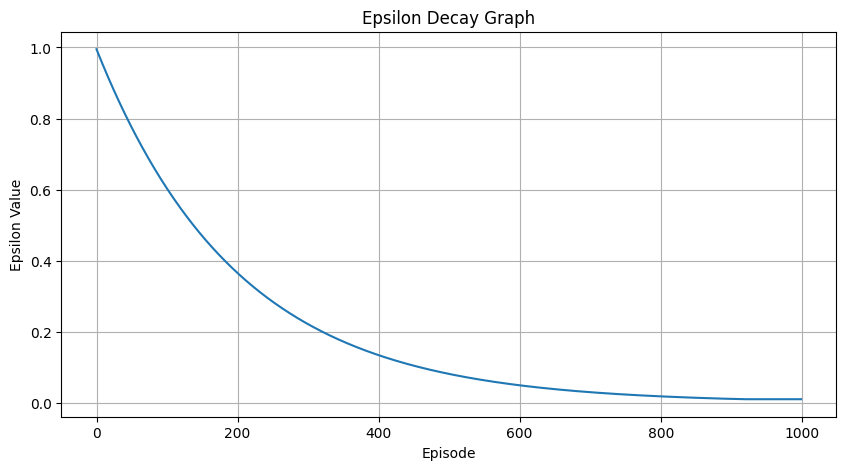

Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3


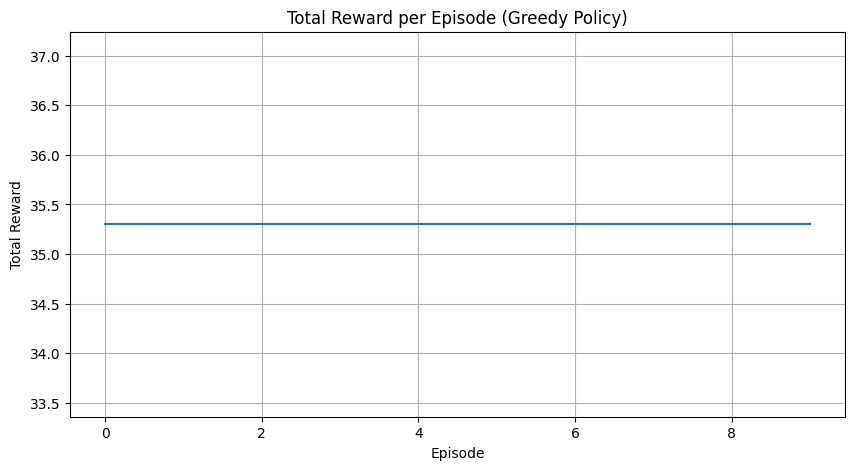

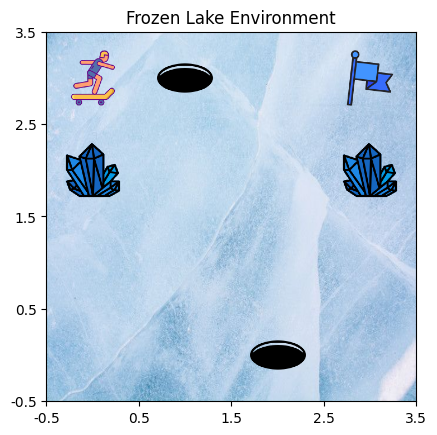

Max Timestamp, Gamma:  15, 0.5
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 3.11974142  2.68553652  2.24938732  2.22057957]
 [ 2.51368051  2.83313258  6.68685471  0.51272537]
 [ 0.          0.          0.          0.        ]
 [-3.46084526  2.96864408  2.9518424   6.64672245]
 [-4.76956319  0.48670133  3.13922206  0.53871133]
 [ 2.24929728  2.09227871  4.27253867  0.03800519]
 [ 4.78495356  6.54229326 -3.71127204  0.99255012]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.1799598  -0.35929486  1.41791067 -4.81759153]
 [ 7.57992461  1.38931522  4.28202315 -0.74812137]
 [11.49570705 -2.00163377  1.29435666  0.67670412]
 [ 0.19178721 -3.30548988  3.72793318  0.02745277]
 [ 1.16096151 -0.94673584  7.4

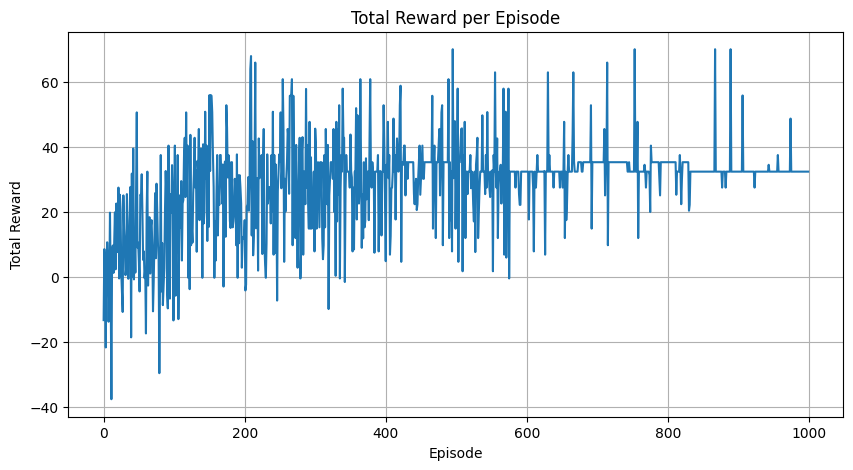

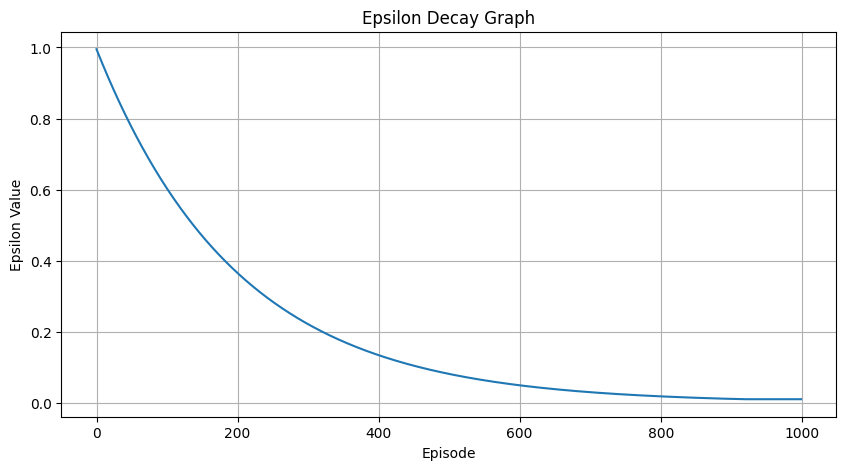

Episode 1000 Reward: 32.4
Episode 1000 Reward: 32.4
Episode 1000 Reward: 32.4
Episode 1000 Reward: 32.4
Episode 1000 Reward: 32.4
Episode 1000 Reward: 32.4
Episode 1000 Reward: 32.4
Episode 1000 Reward: 32.4
Episode 1000 Reward: 32.4
Episode 1000 Reward: 32.4


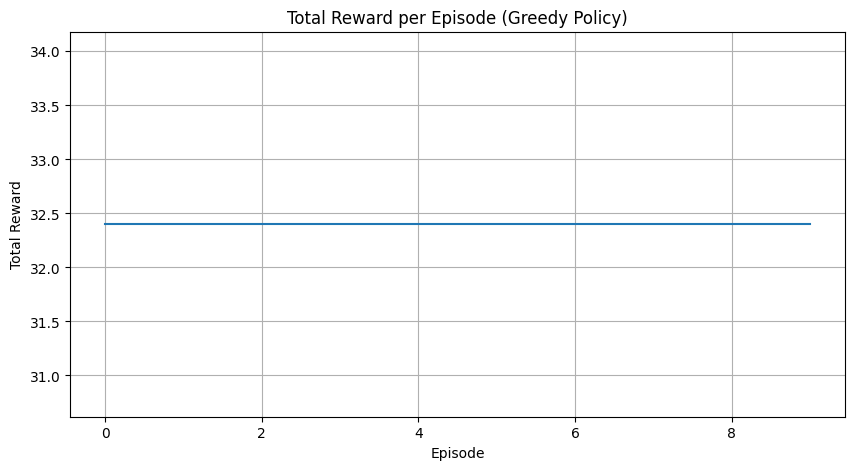

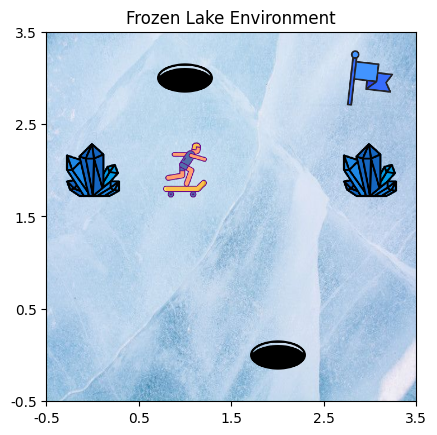

Max Timestamp, Gamma:  15, 0.9
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[16.85752299 15.23713953 23.13101534 17.08314036]
 [15.70901662 20.08488344 25.47833358 15.44877623]
 [ 0.          0.          0.          0.        ]
 [13.58584971 22.50660951 22.11802332 25.79626659]
 [ 4.0589532  13.90587393  9.12726468  7.18862321]
 [ 3.34106899  6.06856752 20.47557416  1.21971255]
 [10.13547125 24.48464203  4.83818212  7.21909305]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.78683209 -0.64211503  9.7642699  -3.21125807]
 [16.64748005  5.66698985  5.05207127 -0.41991785]
 [20.09686316 -0.63928066  2.44841659  2.89269358]
 [ 0.         -2.92648068  1.9728713  -0.38943096]
 [ 1.67984322 -0.41964927 12.8

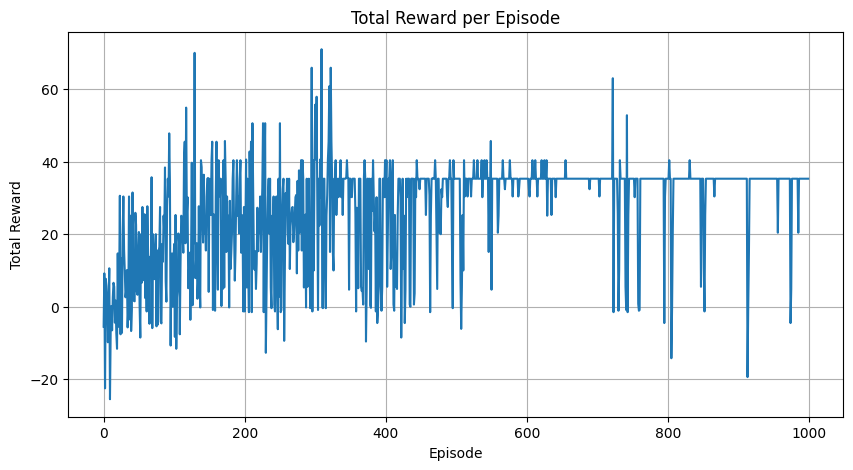

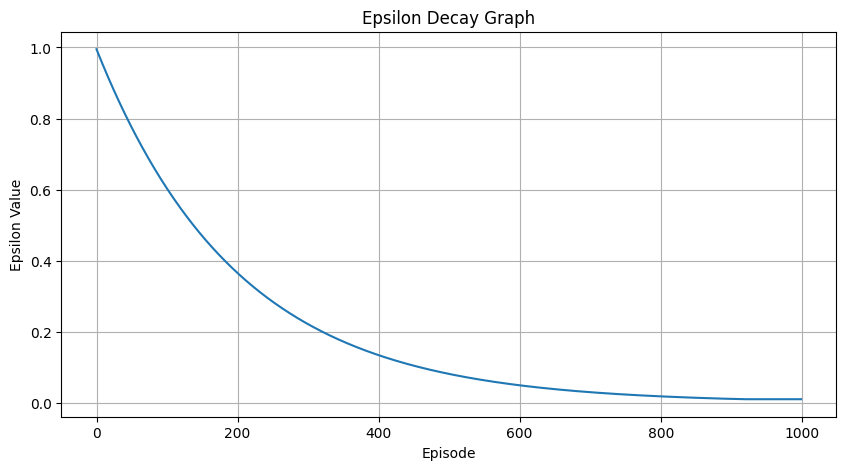

Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3
Episode 1000 Reward: 35.3


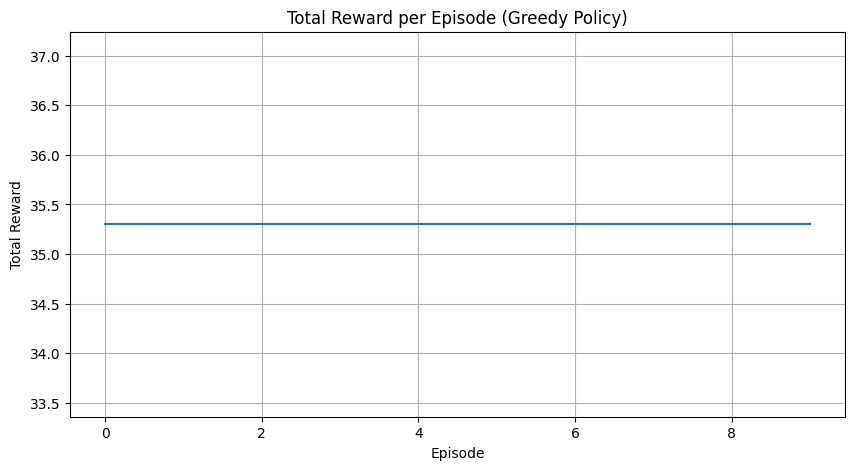

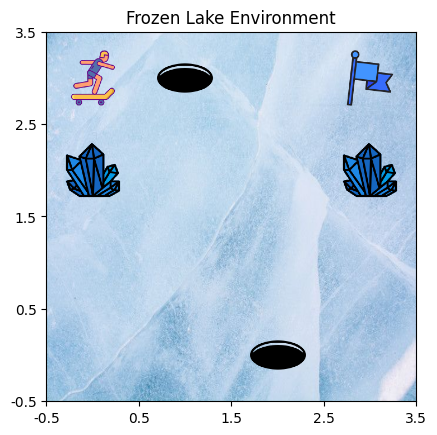

Max Timestamp, Gamma:  20, 0.1
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 4.43053646e-01  2.95084561e-01  3.62881199e-01  3.69248167e-01]
 [ 1.13816429e+00  3.33230182e-01  5.05508330e+00 -8.26814413e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.93019227e+00  3.63659175e-01  3.42235424e-01  5.05074434e+00]
 [-5.84804755e+00 -9.04842732e-01  1.14458402e+00 -4.95019581e-02]
 [ 1.13479344e+00 -5.14983058e-01  1.45768559e+00 -8.95523790e-01]
 [ 1.61045206e+00  5.04742724e+00 -4.95461675e+00 -8.51420893e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.48106921e+00 -9.06242037e-01  1.24433503e+00 -5.21780891e+00]
 [ 6.12314016e+00 -6.41

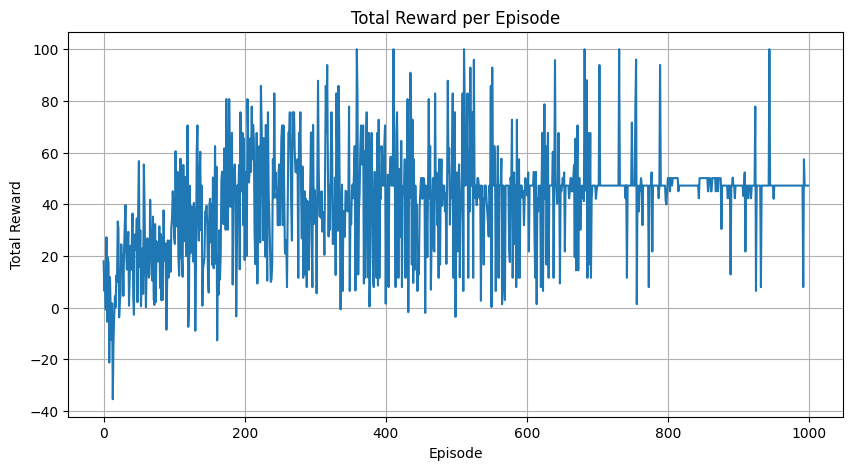

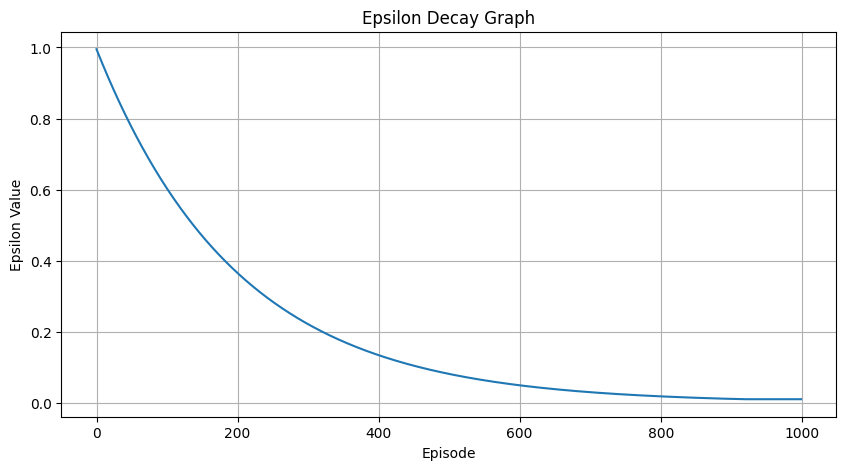

Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2


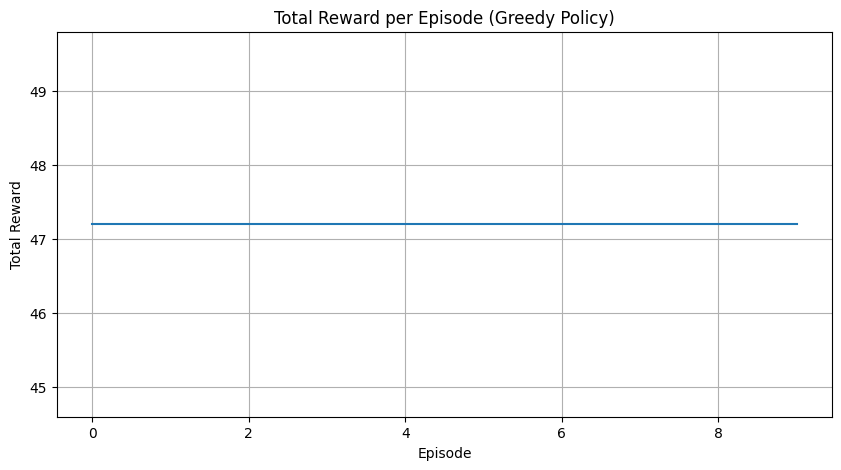

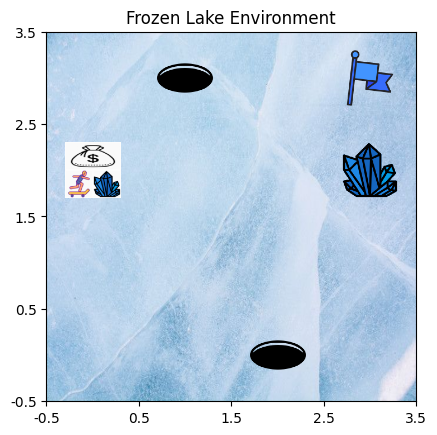

Max Timestamp, Gamma:  20, 0.5
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[ 2.80140086  2.29141571  1.50674863  2.21839578]
 [ 2.88028381  2.85349185  6.70884556  0.69563842]
 [ 0.          0.          0.          0.        ]
 [-3.7266302   3.11850404  3.10170484  6.68990091]
 [-4.35141657  0.81680433  3.14075811  1.31872786]
 [ 3.06115883  1.8444792   4.27366258 -0.2095464 ]
 [ 4.70256176  6.5526174  -3.75862961  1.05226928]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30151004 -0.27890809  4.63057866 -5.18575134]
 [ 7.4822859   1.53068121  4.51557474  0.07792832]
 [11.4532884  -3.64146099  1.74835215  1.03688358]
 [ 0.2717747  -3.31026696  3.83021661 -0.15903388]
 [ 1.52383562  0.03544094  8.1

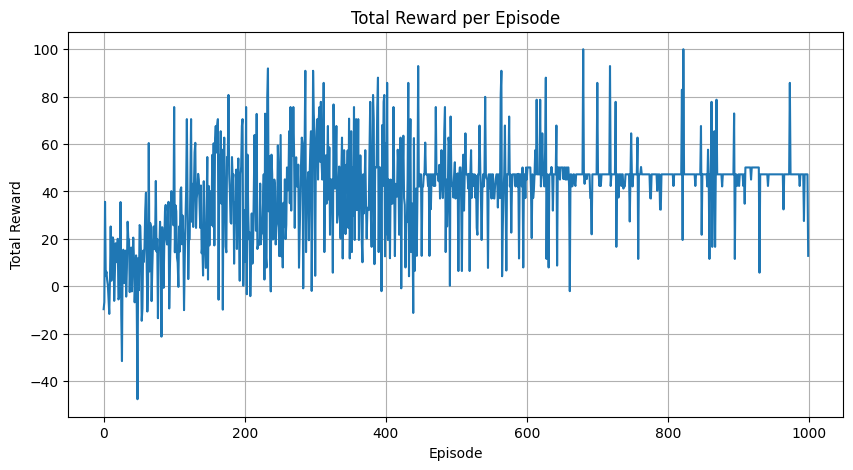

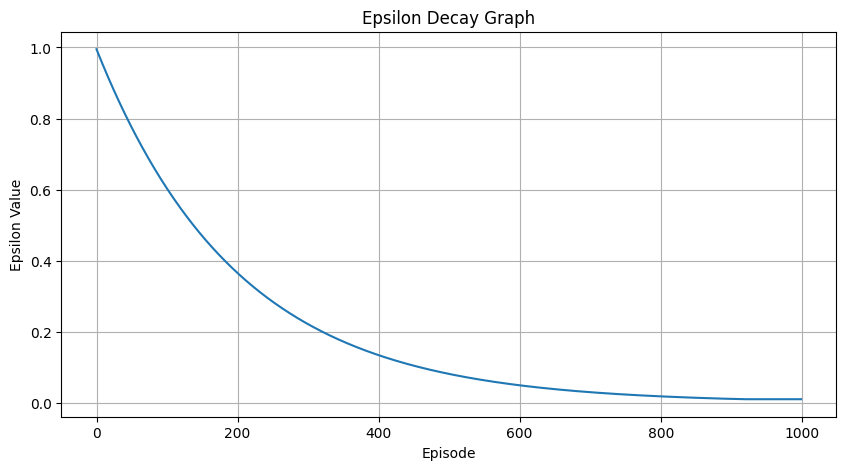

Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2
Episode 1000 Reward: 47.2


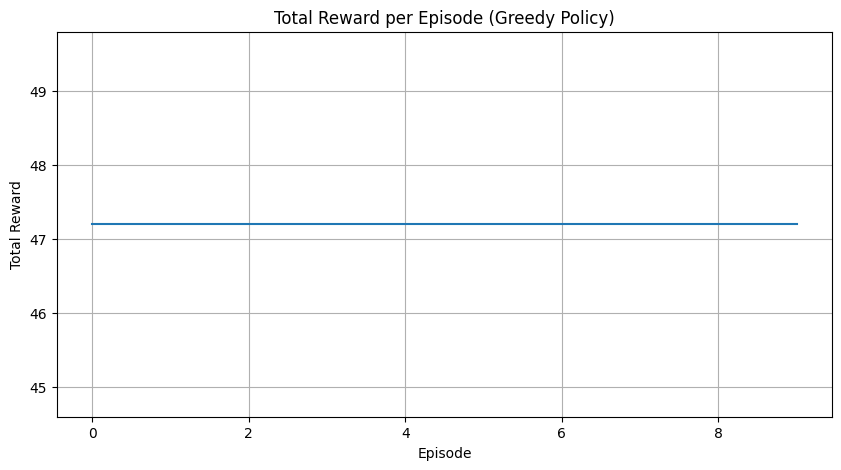

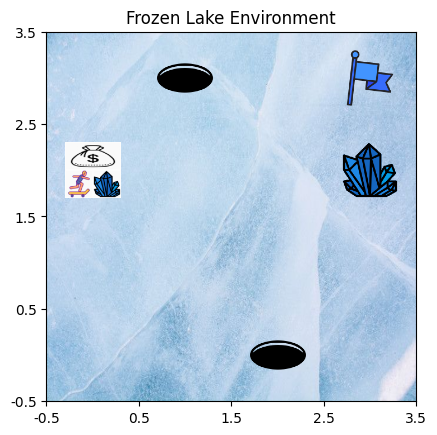

Max Timestamp, Gamma:  20, 0.9
Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[22.15222844 23.13187901 23.66010883 21.95425907]
 [15.71255487 14.94072177 26.43702285 16.1288153 ]
 [ 0.          0.          0.          0.        ]
 [13.99774672 22.69788479 22.98321277 26.32911041]
 [ 9.69853232 11.86554135 21.86367783 11.54124572]
 [11.92411134 16.67945391 23.83433094 10.19013469]
 [23.3624527  25.69324499 13.60450976 19.15333573]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.27428097  2.71488241 18.78650441 -1.04362204]
 [25.74188875  9.86893908 14.37017121  7.53119174]
 [27.48685055  1.76556627  3.451862    5.43124556]
 [-0.53534597 -2.56501807  6.75257209 -0.0543923 ]
 [ 3.99119803 -0.10051165 24.8

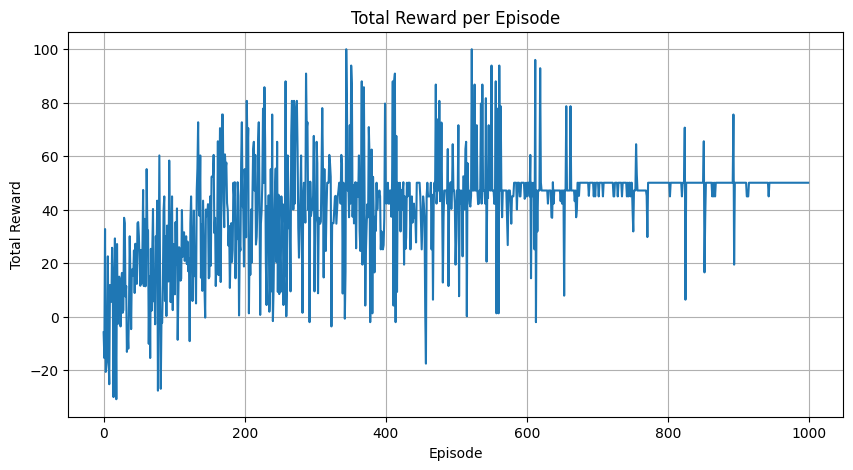

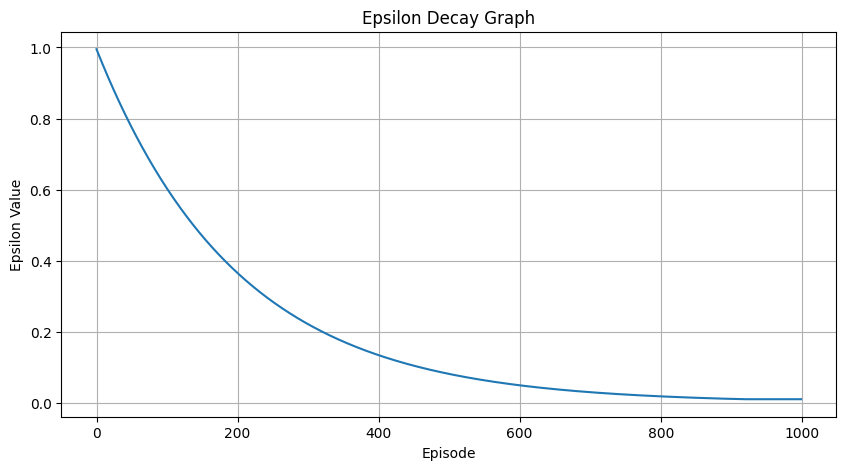

Episode 1000 Reward: 50.1
Episode 1000 Reward: 50.1
Episode 1000 Reward: 50.1
Episode 1000 Reward: 50.1
Episode 1000 Reward: 50.1
Episode 1000 Reward: 50.1
Episode 1000 Reward: 50.1
Episode 1000 Reward: 50.1
Episode 1000 Reward: 50.1
Episode 1000 Reward: 50.1


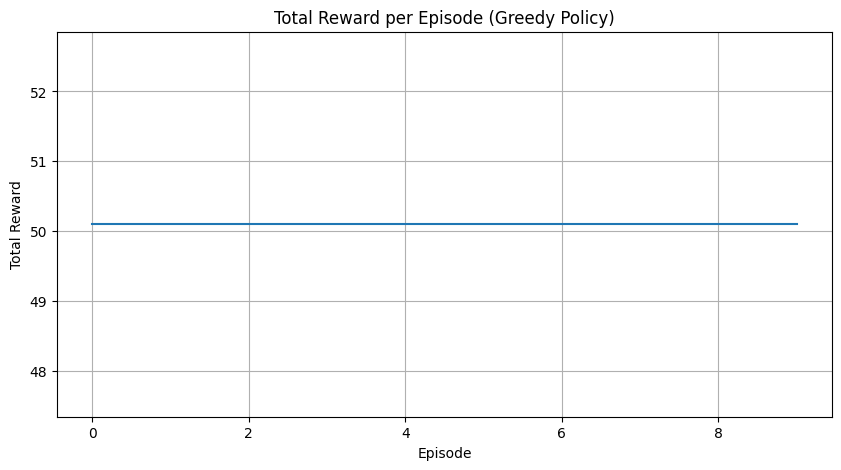

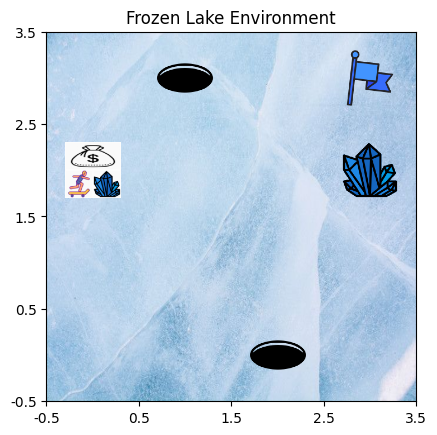

In [13]:
max_timestamp_values = [12, 15, 20]
gamma_values = [0.1, 0.5, 0.9]

for mt in max_timestamp_values:
    for gamma in gamma_values:
        env_det = FrozenLakeEnv(gamma=gamma, alpha=0.15, max_timestamp=mt)
        qt, rewards_epi, epsilon_values, final_state = training_loop(env_det, gamma, mt)
        evaluate_loop(env_det, mt, gamma, qt, rewards_epi, epsilon_values, final_state)